#### import packages and data

In [1]:
import decoupler as dc
import omnipath as   op

In [2]:
import anndata as ad

In [3]:
import gseapy as gp

In [4]:
import numpy as np
import scanpy as sc
import seaborn as sns

In [5]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
adata_r1 = ad.read('dyno1.h5ad')
adata_r2 = ad.read('dyno2.h5ad')
adata_r3 = ad.read('dyno3.h5ad')
adata_r4 = ad.read('dyno4.h5ad')
adata_r5 = ad.read('dyno5.h5ad')
adata_r6 = ad.read('dyno6.h5ad')

#### Pseudobulk

In [8]:
adata_r1.obs['sample']='r1'
adata_r2.obs['sample']='r2'
adata_r3.obs['sample']='r3'
adata_r4.obs['sample']='r4'
adata_r5.obs['sample']='r5'
adata_r6.obs['sample']='r6'
adata_r1.obs['condition']='CTRL'
adata_r2.obs['condition']='DYMK'
adata_r3.obs['condition']='CTRL'
adata_r4.obs['condition']='CTRL'
adata_r5.obs['condition']='DYMK'
adata_r6.obs['condition']='DYMK'

In [9]:
adata_tot=adata_r1.concatenate(adata_r2,adata_r3,adata_r4,adata_r5,adata_r6)

In [10]:
sample_colors = ['green', 'red', 'blue','pink','purple','brown']  # Adjust colors as needed

# Assign the colors to `adata.uns`
adata_tot.uns['sample_colors'] = sample_colors


In [11]:
adata_tot=adata_tot[adata_tot.obs['region']=='center']

In [12]:
adata_tot.X = np.round(adata_tot.X)
adata_tot.layers['counts'] = adata_tot.X

pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

/tmp/ipykernel_3315432/32197127.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_tot.layers['counts'] = adata_tot.X


In [13]:
pdata.obs['sample']

r1_center    r1
r2_center    r2
r3_center    r3
r4_center    r4
r5_center    r5
r6_center    r6
Name: sample, dtype: object

In [14]:
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


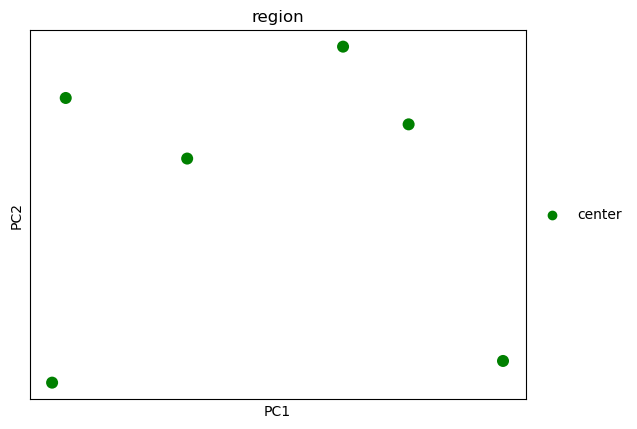

In [15]:
# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)
sc.pl.pca(pdata, color=['region'], ncols=1, size=300,palette=sample_colors )

/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


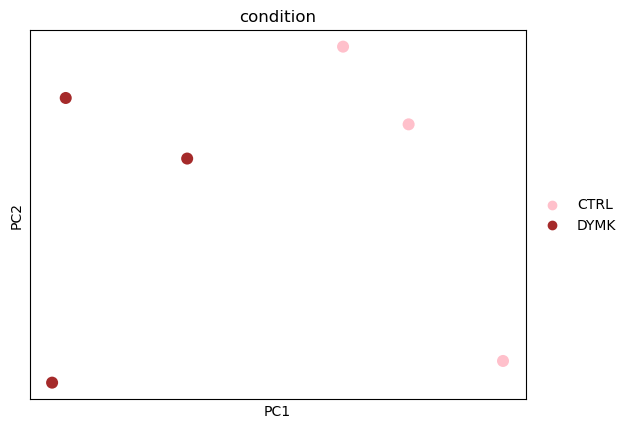

In [16]:
#sc.pl.pca(pdata, color=['condition'], ncols=1, size=300)
#plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/PCADYNO.svg',dpi=300)
fig = sc.pl.pca(pdata, color=['condition'], ncols=1, size=300, return_fig=True,palette=['pink','brown'])
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/PCA_DYNO.pdf', dpi=300,
         
         bbox_inches="tight"  )


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


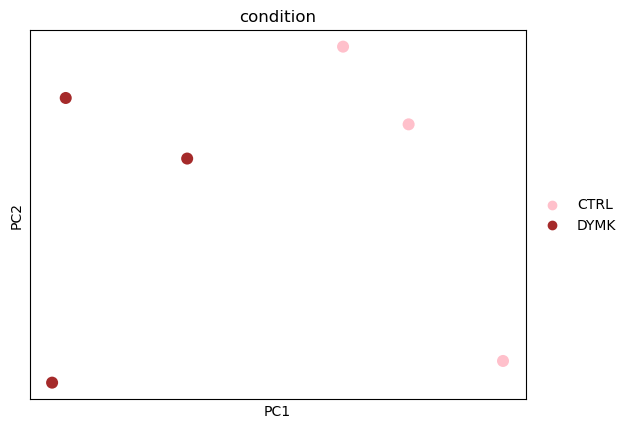

In [17]:
#sc.pl.pca(pdata, color=['condition'], ncols=1, size=300)
#plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/PCADYNO.svg',dpi=300)
fig = sc.pl.pca(pdata, color=['condition'], ncols=1, size=300, return_fig=True,palette=['pink','brown'])
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/PCA_DYNO.svg', dpi=300,
         
         bbox_inches="tight"  )


In [18]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

#### Differential expression

In [19]:
pdata.X=pdata.layers['counts'] 

In [20]:
from pydeseq2.dds import DeseqDataSet, DefaultInference

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='condition',
    ref_level=['condition', 'CTRL'],
    refit_cooks=False, inference=inference,
)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.43 seconds.

Fitting dispersion trend curve...
/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 1.47 seconds.

Fitting LFCs...
... done in 2.87 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.64 seconds.



Log2 fold change & Wald test p-value: condition CTRL vs DYMK
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       58.237262        1.106792  0.808899  1.368269  0.171228  0.967076
A1BG-AS1    5.758862        6.076673  4.209082  1.443705  0.148822       NaN
A2M       167.854413       -0.533597  0.426728 -1.250438  0.211140  0.999997
A2M-AS1    27.024435        0.331980  3.577961  0.092785  0.926075  0.999997
A2ML1      20.287463       -1.671918  3.737785 -0.447302       NaN       NaN
...              ...             ...       ...       ...       ...       ...
ZXDC       35.133229        0.002604  1.680030  0.001550  0.998763  0.999997
ZYG11A      5.603217        6.037181  4.209289  1.434252  0.151500       NaN
ZYG11B     63.582681       -0.069649  0.565021 -0.123268  0.901895  0.999997
ZYX        91.262636       -0.259149  0.551494 -0.469904  0.638423  0.999997
ZZEF1      63.659242       -0.431323  0.670668 -0.643125  0.520143  0.999997

[20619 rows x 

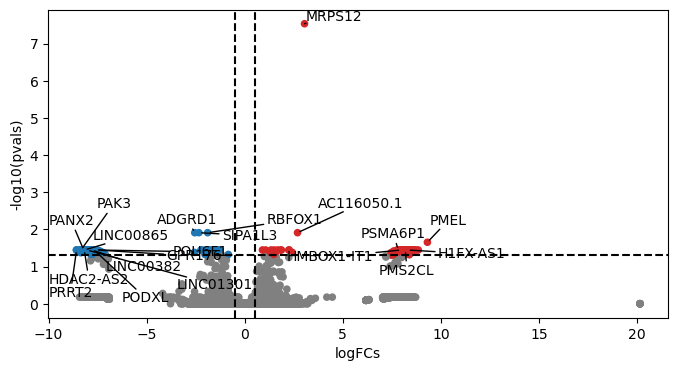

In [21]:
# Compute LFCs
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'CTRL', 'DYMK'],
    inference=inference,
)
# Compute Wald test
stat_res.summary()
results_df = stat_res.results_df
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/vulcanoDYNO.svg',dpi=300)


In [22]:
results_df_adj=results_df[results_df['padj']<0.05]
results_core=results_df_adj[results_df_adj['log2FoldChange']>0]
results_core=results_core.sort_values(by='log2FoldChange',ascending=False)
results_core.index

Index(['PMEL', 'AP001528.3', 'RND2', 'GPNMB', 'SLC27A3', 'PCSK1N', 'NACA2',
       'SLC25A30', 'ZNF514', 'MAP3K7CL', 'GPR143', 'FAM216B', 'SCPEP1',
       'GPR162', 'RASA4CP', 'KCTD6', 'RPL35P2', 'H1FX-AS1', 'AC027309.2',
       'ZNF583', 'BOLA2-SMG1P6', 'PMS2CL', 'ZNF320', 'HIST1H2BK', 'RNF128',
       'AL121899.1', 'ZNF582', 'AL136126.1', 'CHRD', 'HMBOX1-IT1', 'LINC01732',
       'SGSM1', 'LINC00630', 'AP002387.2', 'TMEM254', 'TMEM139', 'ZNF7',
       'AC091180.5', 'PCDHB16', 'AC016705.2', 'KCNJ2-AS1', 'PSMA6P1',
       'AC025627.1', 'TIGD6', 'ASH1L-AS1', 'LINC02001', 'HNF1A-AS1',
       'SAPCD1-AS1', 'FTLP3', 'NMNAT2', 'PRKCD', 'STPG1', 'TPTE2P3',
       'AC087343.1', 'AC090152.1', 'SLC2A10', 'AC022146.2', 'MRPS12',
       'AC116050.1', 'HPF1', 'GALNTL6', 'APOE', 'ZNF43', 'ZMAT5', 'MPC1',
       'MAPRE2', 'PCNA', 'SEPHS1', 'MTIF3', 'SCAND2P', 'FAM213A', 'BEX4',
       'MYZAP'],
      dtype='object')

In [23]:
results_border=results_df_adj[results_df_adj['log2FoldChange']<0]
results_border=results_border.sort_values(by='log2FoldChange',ascending=True)
results_border.index

Index(['ARNTL2-AS1', 'PRRT2', 'TECPR1', 'ESRRB', 'AC026979.3', 'AL356270.1',
       'PAK3', 'RPS10P2', 'BX255923.1', 'AL121832.2',
       ...
       'RFX3', 'SS18L2', 'B3GAT3', 'HAND1', 'YEATS2', 'FGF12', 'TTLL5', 'MTAP',
       'BRINP3', 'PACS1'],
      dtype='object', length=111)

In [24]:
mat = results_df[['stat']].T.rename(index={'stat': 'core'})
mat

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,AAAS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
core,1.368269,1.443705,-1.250438,0.092785,-0.447302,-1.300698,-0.18033,-1.458445,-1.042375,0.990021,...,-1.340424,-0.209517,-0.557854,0.304953,0.473908,0.00155,1.434252,-0.123268,-0.469904,-0.643125


#### GSEA

In [25]:
samples=list(pdata.obs.index)
genes=list(pdata.var.index)
gseainp=pd.DataFrame(pdata.X.T)
gseainp.columns=samples
gseainp.index=genes
gseainp

,r1_center,r2_center,r3_center,r4_center,r5_center,r6_center
A1BG,88.0,55.0,46.0,90.0,18.0,42.0
A1BG-AS1,0.0,0.0,37.0,0.0,0.0,0.0
A2M,238.0,204.0,126.0,73.0,244.0,197.0
A2M-AS1,24.0,0.0,76.0,0.0,0.0,69.0
A2ML1,36.0,97.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
ZXDC,0.0,47.0,67.0,31.0,31.0,34.0
ZYG11A,0.0,0.0,36.0,0.0,0.0,0.0
ZYG11B,60.0,79.0,62.0,58.0,103.0,35.0
ZYX,117.0,117.0,115.0,34.0,143.0,69.0


In [26]:
rnk=pd.DataFrame(results_df.iloc[:,3])
rnk

,stat
A1BG,1.368269
A1BG-AS1,1.443705
A2M,-1.250438
A2M-AS1,0.092785
A2ML1,-0.447302
...,...
ZXDC,0.001550
ZYG11A,1.434252
ZYG11B,-0.123268
ZYX,-0.469904


In [27]:
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets='/group/neur6/jupyterlab/c5.go.v2023.2.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2025-03-14 14:05:05,506 [WARNING] Duplicated values found in preranked stats: 21.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-14 14:05:05,507 [INFO] Parsing data files for GSEA.............................
2025-03-14 14:05:05,711 [INFO] 1254 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-03-14 14:05:05,713 [INFO] 9207 gene_sets used for further statistical testing.....
2025-03-14 14:05:05,713 [INFO] Start to run GSEA...Might take a while..................
2025-03-14 14:08:26,399 [INFO] Congratulations. GSEApy runs successfully................



In [28]:
tb=pre_res.res2d.sort_values('NES',ascending=True)

In [29]:
terms = pre_res.res2d.Term

#### Genes negatively enriched in the Core

In [30]:
tb.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
56,prerank,GOMF_COLLAGEN_BINDING,-0.513384,-1.944499,0.0,1.0,0.703,18/58,22.74%,VWF;COL14A1;CD44;COL6A1;COL5A3;LOX;FN1;DDR2;SP...
64,prerank,GOMF_VOLTAGE_GATED_CALCIUM_CHANNEL_ACTIVITY_IN...,-0.963872,-1.8842,0.0,1.0,0.935,4/5,1.45%,CACNB2;CACNA1G;CACNA1D;CACNA1C
65,prerank,GOMF_SOLUTE_POTASSIUM_ANTIPORTER_ACTIVITY,-0.65207,-1.858647,0.0,1.0,0.977,9/16,22.03%,SLC9A1;SLC24A4;SLC9C2;SLC9A4;SLC9A5;SLC24A2;SL...
70,prerank,GOMF_EXCITATORY_EXTRACELLULAR_LIGAND_GATED_MON...,-0.618636,-1.848322,0.001842,1.0,0.986,10/21,17.09%,P2RX7;TRPV1;ZACN;CHRNA10;P2RX1;CHRNB2;CHRNA2;C...
72,prerank,GOCC_FILTRATION_DIAPHRAGM,-0.935498,-1.843525,0.0,1.0,0.986,4/5,4.85%,TRPC6;PODXL;IQGAP1;PPP3CA
74,prerank,GOMF_EXTRACELLULAR_LIGAND_GATED_MONOATOMIC_ION...,-0.504241,-1.836493,0.001773,1.0,0.99,19/46,21.56%,P2RX7;TRPV1;GRIA4;GABRA2;GABRA3;ZACN;CHRNA10;P...
83,prerank,GOMF_POSTSYNAPTIC_NEUROTRANSMITTER_RECEPTOR_AC...,-0.49702,-1.810572,0.00369,1.0,1.0,21/49,22.02%,CHRM2;GRIA4;GABRA2;DRD3;ADRB1;ZACN;CHRNA10;HRH...
86,prerank,GOMF_GAMMA_CATENIN_BINDING,-0.72419,-1.804235,0.003617,1.0,1.0,2/10,4.49%,TCF7L2;PTPRK
90,prerank,GOMF_TRANSMEMBRANE_RECEPTOR_PROTEIN_PHOSPHATAS...,-0.666669,-1.799796,0.009009,1.0,1.0,12/14,31.99%,PTPRM;PTPRA;PTPRK;PTPRO;PTPRH;PTPN6;PTPRG;PTPR...
92,prerank,GOBP_PROXIMAL_DISTAL_PATTERN_FORMATION,-0.604241,-1.795244,0.005386,1.0,1.0,9/18,30.80%,GLI2;HES5;CHSY1;GLI1;GREM1;ALDH1A2;IRX3;LRP4;GLI3


#### Genes positively enriched in the Core

In [31]:
tb.tail(15)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
14,prerank,GOCC_OXIDOREDUCTASE_COMPLEX,0.536179,2.42484,0.0,0.00007,0.001,60/113,22.07%,MRPS36;SDHA;NDUFC2-KCTD14;NDUFB9;NDUFAB1;NDUFB...
13,prerank,GOCC_RIBOSOMAL_SUBUNIT,0.500269,2.427245,0.0,0.000075,0.001,106/184,30.26%,MRPS12;MRPL17;MRPL41;MRPL3;RPS27A;MRPS30;MRPL3...
12,prerank,GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_...,0.622724,2.445081,0.0,0.000081,0.001,29/50,19.17%,NDUFC2-KCTD14;NDUFB9;NDUFAB1;NDUFB4;NDUFS3;NDU...
11,prerank,GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_A...,0.559775,2.458461,0.0,0.000088,0.001,57/96,24.25%,NDUFB9;COX16;NDUFAB1;NDUFB4;DMAC1;NDUFS3;NDUFA...
10,prerank,GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME,0.52092,2.466748,0.0,0.000096,0.001,95/160,30.61%,MRPS12;MRPL17;MRPL41;MRPL3;RPS27A;MRPS30;MRPL3...
9,prerank,GOMF_OXIDOREDUCTION_DRIVEN_ACTIVE_TRANSMEMBRAN...,0.61276,2.518548,0.0,0.0,0.0,38/67,19.17%,COX7B;NDUFB9;COX7A1;COX5A;NDUFB4;UQCR10;NDUFS3...
8,prerank,GOCC_CYTOCHROME_COMPLEX,0.695629,2.555338,0.0,0.0,0.0,22/38,15.47%,COX7B;COX7A1;COX5A;COX6C;COX6A2;COX7C;UQCR10;C...
7,prerank,GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN,0.569814,2.56809,0.0,0.0,0.0,62/120,22.07%,COX7B;SDHA;NDUFC2-KCTD14;NDUFB9;COX7A1;COX5A;C...
6,prerank,GOBP_ATP_BIOSYNTHETIC_PROCESS,0.597186,2.580346,0.0,0.0,0.0,59/90,25.29%,ATP5ME;SDHA;NDUFB9;ATP5MC3;NDUFAB1;ATP5F1D;NDU...
5,prerank,GOBP_OXIDATIVE_PHOSPHORYLATION,0.576263,2.655939,0.0,0.0,0.0,76/139,22.48%,ATP5ME;COX7B;SDHA;NDUFC2-KCTD14;NDUFB9;COX7A1;...


In [32]:
list(tb.head(15)['Term'])

['GOMF_COLLAGEN_BINDING',
 'GOMF_VOLTAGE_GATED_CALCIUM_CHANNEL_ACTIVITY_INVOLVED_IN_CARDIAC_MUSCLE_CELL_ACTION_POTENTIAL',
 'GOMF_SOLUTE_POTASSIUM_ANTIPORTER_ACTIVITY',
 'GOMF_EXCITATORY_EXTRACELLULAR_LIGAND_GATED_MONOATOMIC_ION_CHANNEL_ACTIVITY',
 'GOCC_FILTRATION_DIAPHRAGM',
 'GOMF_EXTRACELLULAR_LIGAND_GATED_MONOATOMIC_ION_CHANNEL_ACTIVITY',
 'GOMF_POSTSYNAPTIC_NEUROTRANSMITTER_RECEPTOR_ACTIVITY',
 'GOMF_GAMMA_CATENIN_BINDING',
 'GOMF_TRANSMEMBRANE_RECEPTOR_PROTEIN_PHOSPHATASE_ACTIVITY',
 'GOBP_PROXIMAL_DISTAL_PATTERN_FORMATION',
 'GOMF_NEUROTRANSMITTER_RECEPTOR_ACTIVITY',
 'GOMF_L_ALANINE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY',
 'GOBP_REGULATION_OF_HIPPO_SIGNALING',
 'GOBP_CELLULAR_RESPONSE_TO_EPINEPHRINE_STIMULUS',
 'GOBP_CELL_PROLIFERATION_IN_HINDBRAIN']

In [33]:
list(tb.tail(15)['Term'])

['GOCC_OXIDOREDUCTASE_COMPLEX',
 'GOCC_RIBOSOMAL_SUBUNIT',
 'GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_UBIQUINONE',
 'GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY',
 'GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME',
 'GOMF_OXIDOREDUCTION_DRIVEN_ACTIVE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY',
 'GOCC_CYTOCHROME_COMPLEX',
 'GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN',
 'GOBP_ATP_BIOSYNTHETIC_PROCESS',
 'GOBP_OXIDATIVE_PHOSPHORYLATION',
 'GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS',
 'GOCC_MITOCHONDRIAL_PROTEIN_CONTAINING_COMPLEX',
 'GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX',
 'GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT',
 'GOCC_RESPIRASOME']

In [34]:
def round_to_2_sig_figs(x):
    if isinstance(x, float):
        return float(f"{x:.2g}")
    return x

### Plots

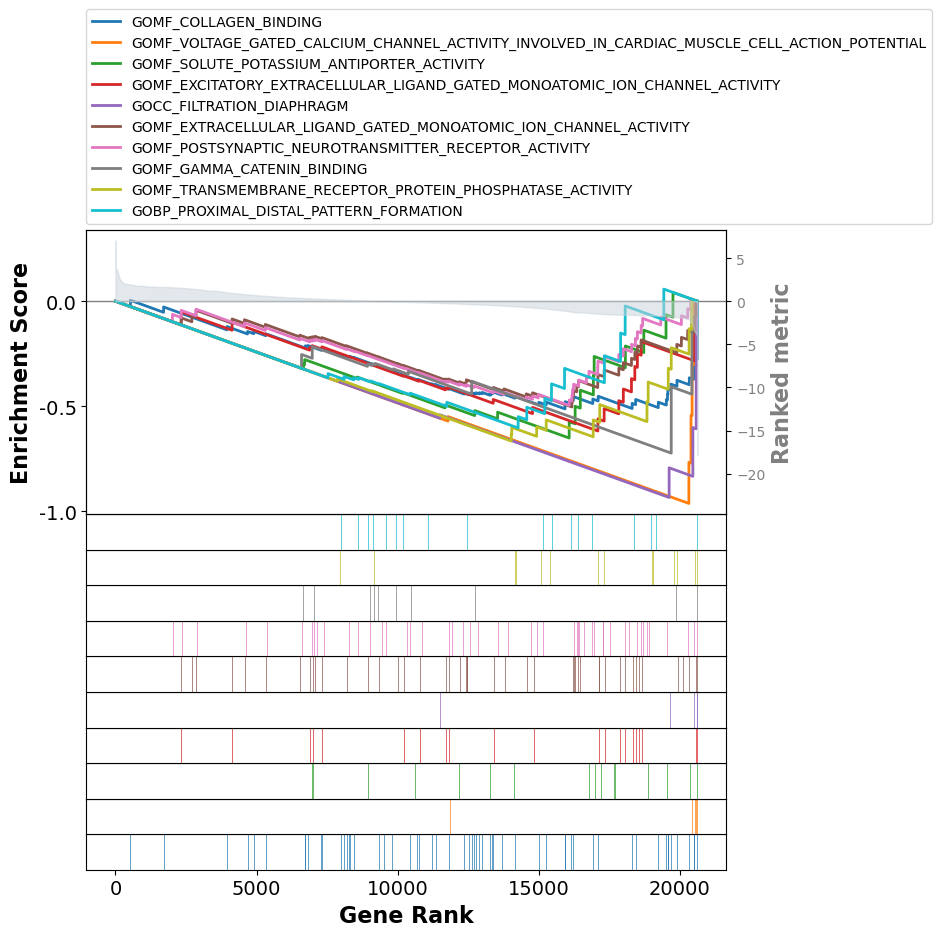

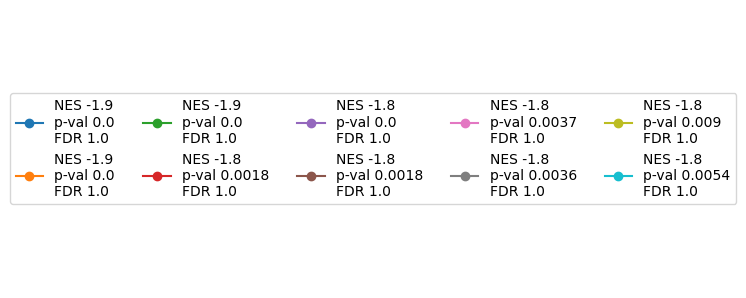

In [35]:
axs = pre_res.plot(terms=list(tb.head(10)['Term']))


fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseaDYNO1.svg',
            dpi=300, bbox_inches="tight")
#fig.savefig('gsea_plot8terms_version2.svg', dpi=300, bbox_inches='tight')
plt.show()
#legend
subset_gsea = tb[tb['Term'].isin(list(tb.head(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.head(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseaDYNO1legend.svg',dpi=300,
         bbox_inches="tight"  )
plt.show()

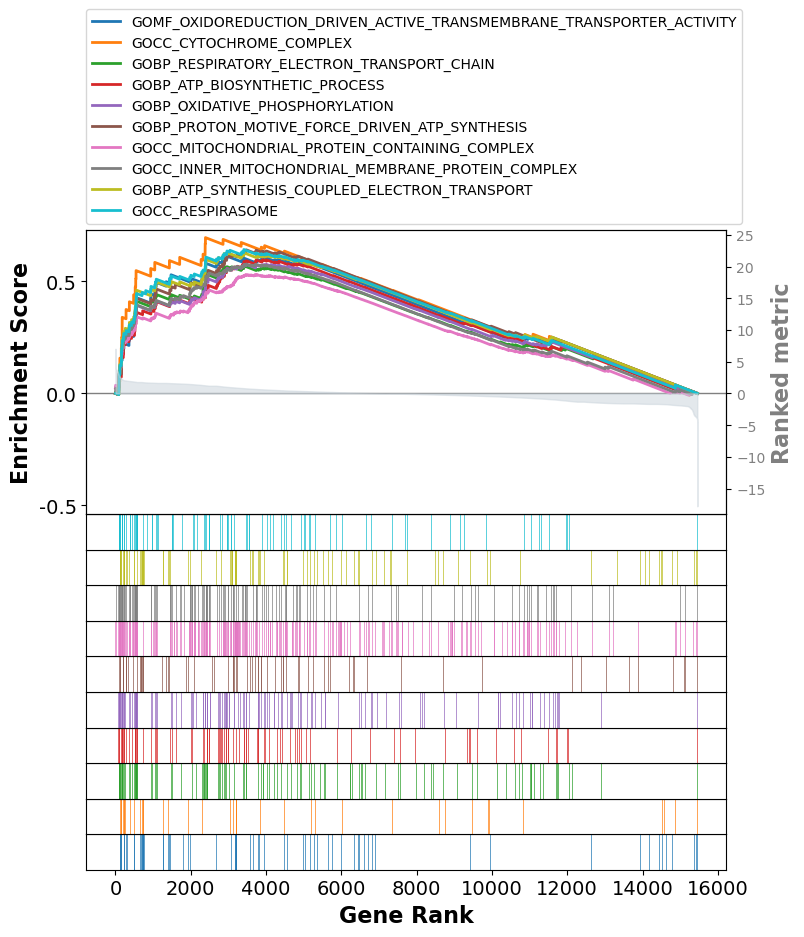

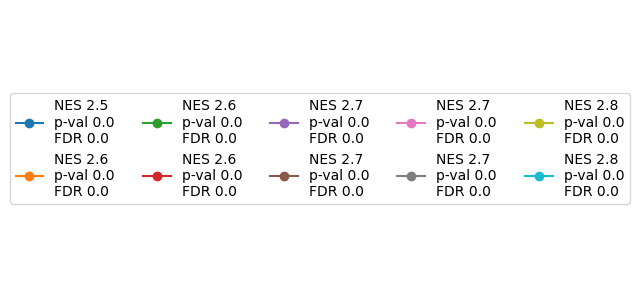

In [36]:
axs = pre_res.plot(terms=list(tb.tail(10)['Term']))

fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseaDYNO2.svg',
            dpi=300, bbox_inches="tight")
#fig.savefig('gsea_plot8terms_version2.svg', dpi=300, bbox_inches='tight')

plt.show()

#fig.savefig('gsea_plot8terms_version2.svg', dpi=300, bbox_inches='tight')

#legend
subset_gsea = tb[tb['Term'].isin(list(tb.tail(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.tail(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseaDYNO2legend.svg',dpi=300,
         bbox_inches="tight"  )
# Show the plot
plt.show()